#**Machine Translation**








Let's download our dataset of English and Spanish translations.

In [1]:
import pathlib
import keras
import os
import random

zip_path = keras.utils.get_file(
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    fname='spa-eng.zip',
    extract=True # Download
)

# Construct text_path with the correct subdirectory
text_path = os.path.join(zip_path+'/spa-eng/', 'spa.txt')

# Let's iterate over all lines in the text file (pairs of English and Spanish translations) and split by line breaks
with open(text_path) as f:
    lines = f.read().split("\n")[:-1]

# Let's put our English-Spanish text pairs into a list; the sentences are split by a tab character.
text_pairs = []
for line in lines:
    english, spanish = line.split("\t")

    # Let's add a start and end token to the Spanish output (we will train an English --> Spanish translator model.)
    spanish = "[start] " + spanish + " [end]"
    text_pairs.append((english, spanish))

# Let's pull a random example pair.
random.choice(text_pairs)

2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


("I'm glad we agree on something.",
 '[start] Me alegra que estemos de acuerdo en algo. [end]')

Randomly shuffling the observations

In [2]:
# Shuffle the data to make a training and validation split.
random.shuffle(text_pairs)

# Define split percentages
train_split = 0.70  # 70% for training
val_split = 0.15   # 15% for validation
test_split = 0.15  # 15% for testing

# Calculate the number of samples for each split
total_samples = len(text_pairs)
train_samples = int(train_split * total_samples)
val_samples = int(val_split * total_samples)
test_samples = int(test_split * total_samples)

# Create the splits
train_pairs = text_pairs[:train_samples]
val_pairs = text_pairs[train_samples:train_samples + val_samples]
test_pairs = text_pairs[train_samples + val_samples:]

We need TextVectorization layers to convert raw text into integer indices. Let's create one for each language.

In [3]:
import string
import re
import tensorflow as tf
from keras import layers

# Remove preceding question mark symbols in Spanish text; we need to add this to the punctuation list for removal.
strip_chars = string.punctuation + "¿"

# By default, our string.punctuation includes square brackets. We don't want to throw those out, though.
# So, we are going to drop [ and ] from the standard punctuation list.
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Lower case everything, and replace punctuation with nothing, except for [ and ].
# Note, in practice, we would keep punctuation and treat each as a separate token for prediction.
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# We will make indices for the 15,000 most common words in each language.
vocab_size = 15000

# We will work with sequences of exactly 20 words
sequence_length = 20

english_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Note that we have 21 values in Spanish sequences, because we have to predict the 'end' token.
spanish_tokenizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]

english_tokenizer.adapt(train_english_texts)
spanish_tokenizer.adapt(train_spanish_texts)

Now we will make a Tensorflow Dataset object with the translation examples.

In [4]:
batch_size = 64

# We will call this format_dataset() function inside of the make_dataset() function.
def format_dataset(eng, spa):

    # We will separately tokenize each English and Spanish sequence
    eng = english_tokenizer(eng)
    spa = spanish_tokenizer(spa)

    # We then make a dictionary that relates each English sequence to its associated Spanish sequence (dropping the [end] token).
    features = {"english": eng, "spanish": spa[:, :-1]}

    # Our labels will be everything *after* the [start] token in each Spanish sequence.
    labels = spa[:, 1:]

    # And, if we have a padded sequence, we don't want to count the predictions for padded values in our loss metric.
    # So, we set the weight for those predictions to be 0, and retain equal weighting on the other meaningful predictions.
    sample_weights = labels != 0
    return features, labels, sample_weights

def make_dataset(pairs):

    # We pull out raw English and Spanish text sequences
    eng_texts, spa_texts = zip(*pairs)

    # We turn all those sequences into lists of textual observations.
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)

    # We then use those lists of textual pairs into observations in a Tensorflow Dataset object.
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))

    # We define batches of textual pairs.
    dataset = dataset.batch(batch_size)

    # We then call our format_dataset() function to convert the textual observations into sequences of integers and to define input features (sequences) and associated labels.
    dataset = dataset.map(format_dataset, num_parallel_calls=4)

    # Load the first 2,048 observations of textual pairs, apply the various steps, and shuffle them.
    return dataset.shuffle(2048).cache()

# Let's use the functions we defined above to make our training and validation Tensorflow datasets now.
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Here is what the batches from our dataset now look like...

In [5]:
inputs, targets, sample_weights = next(iter(train_ds))

# We are going to use both the spanish and english sequences as input during the training phase.
print(inputs['english'])
print(inputs['spanish'])

# Later, our model will perform inference in an auto-regressive manner, taking the predictions seen thus far + the english sequence as input for the next translated output word.
print(targets)
print(sample_weights.shape)

tf.Tensor(
[[  6 199   4 ...   0   0   0]
 [  3  22  60 ...   0   0   0]
 [  9 238   7 ...   0   0   0]
 ...
 [  3  32   4 ...   0   0   0]
 [  8  47   7 ...   0   0   0]
 [ 50 101  51 ...   0   0   0]], shape=(64, 20), dtype=int64)
tf.Tensor(
[[   2    8  109 ...    0    0    0]
 [   2    7   14 ...    0    0    0]
 [   2   21  111 ...    0    0    0]
 ...
 [   2   46  290 ...    0    0    0]
 [   2   60   13 ...    0    0    0]
 [   2  200 5605 ...    0    0    0]], shape=(64, 20), dtype=int64)
tf.Tensor(
[[   8  109  520 ...    0    0    0]
 [   7   14  127 ...    0    0    0]
 [  21  111   74 ...    0    0    0]
 ...
 [  46  290   11 ...    0    0    0]
 [  60   13 1555 ...    0    0    0]
 [ 200 5605    3 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20)


Let's create our Neural Network for Training

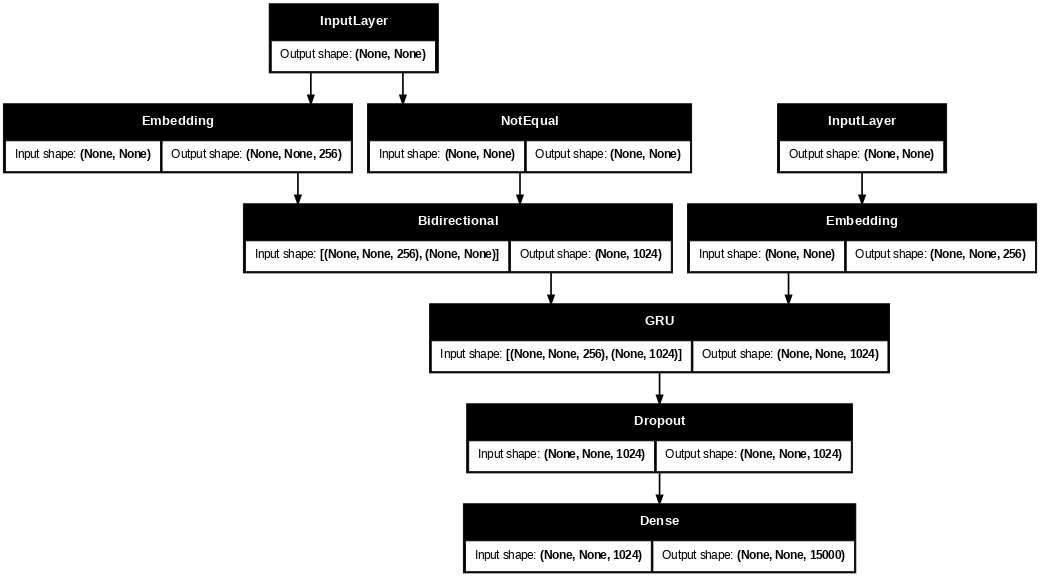

In [6]:
embed_dim = 256
hidden_dim = 1024

# Here is the encoder portion.
# It will accept an English sequence as input, convert the tokens to embeddings
# and pass those sequences of word embeddings into a pair of RNNs (bidirectional) to encode the sequence into a 1,024 dimensional embedded representation.
source = keras.Input(shape=(None,), dtype="int32", name="english")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoder_output = layers.Bidirectional(layers.GRU(hidden_dim), merge_mode="sum")(x)

# Here is the decoder portion of the network.
# It accepts the Spanish sequence (vectorized) as input, which again goes into its own embedding layer, yielding embedded Spanish sequences.
# Those sequences of embedded Spanish words go into their own RNN (unidirectional this time).
# Importantly, *that* RNN implicitly takes the output from the encoder portion as input; the 1,024 embedding of the English sentence is used as the first hidden state for this RNN.
target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(target)

# Notice that we produce output at each step of the sequence.
x = layers.GRU(hidden_dim, return_sequences=True)(x, initial_state=encoder_output)
x = layers.Dropout(0.5)(x)

# So, we are produce 20 * vocab size softmax predictions for each sequence, in parallel. Our model is learning to predict the next word in the Spanish sequence given the words processed thus far
# And the entire English sequence.
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)

# Wrap these things together into a single big Keras model now.
# We connect the aligned English and Spanish sequences as input, to the step ahead Spanish output.
seq2seq_rnn = keras.Model([source, target], target_predictions)

# Notice the shape of the Dense output layer... 15,000 is the softmax dimension (vocabulary size)
# We will produce 'None' 15,000 dimensional softmax predictions - the None is due to the sequence length being left ambiguous in the input layer.
keras.utils.plot_model(seq2seq_rnn, show_shapes=True,dpi=60)

Okay, let's train the model...

In [ ]:
seq2seq_rnn.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)

seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.2614 - loss: 4.5598 - val_accuracy: 0.4913 - val_loss: 2.5391
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5025 - loss: 2.4956 - val_accuracy: 0.5881 - val_loss: 1.9272
Epoch 3/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6038 - loss: 1.7547 - val_accuracy: 0.6236 - val_loss: 1.7201
Epoch 4/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.6680 - loss: 1.3136 - val_accuracy: 0.6397 - val_loss: 1.6623
Epoch 5/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7181 - loss: 1.0258 - val_accuracy: 0.6449 - val_loss: 1.6563
Epoch 6/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7574 - loss: 0.8380 - val_accuracy: 0.6487 - val_loss: 1.6976
Epoch 7/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7844 - loss: 0.7197 - val_accuracy: 0.6506 - val_loss: 1.7269
Epoch 8/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8028 -

Now we can produce use the resulting network to generate translations, feeding predictions back into the network at each step.

In [7]:
import numpy as np

# We need our spanish vocabulary and dictionary to convert integers to words.
spa_vocab = spanish_tokenizer.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

# We write a 'translation' function that wraps our model.
# The function accepts an english sentence as input. In then tokenizes it, and instantiates the output sentence with just a [start] token.
# We will then spit out 20 tokens of text (potentially empty tokens if the sentence finishes).

def generate_translation(input_sentence):
    tokenized_input_sentence = english_tokenizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):

        # At each pass, we obtain the tokenized representation of the output sentence at the current point in time. Initially it is just [start] but it will include more words as we loop.
        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])

        # At a given step, the model takes the English input sentence along with the Spanish output that has been generated thus far.
        inputs = [tokenized_input_sentence, tokenized_target_sentence]

        # We predict the next token in the sequence.
        next_token_predictions = seq2seq_rnn.predict(inputs, verbose=0)

        # We take an arg-max of the prediction at the appropriate index in the output (output token i)
        # NOTE: this is a very inefficient approach, because our model is generating token predictions at positions in the output sequence that are already a done being predicted in prior iterations!
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])

        # We convert that predicted integer token into a word
        sampled_token = spa_index_lookup[sampled_token_index]

        # We add our predicted word to the output sequence and then repeat
        decoded_sentence += " " + sampled_token

        # If we predicted '[end]' then we stop the process.
        if sampled_token == "[end]":
            break

    return decoded_sentence

Now, let's see how our trained model does. It works!

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(generate_translation(input_sentence))

-
A fire broke out during the night.
[start] se produjo un incendio anoche [end]
-
The cat caught the rats.
[start] el gato trepó a las ratas [end]
-
I'm afraid of the dark.
[start] tengo miedo de la oscuridad [end]
-
Open the windows.
[start] abre las ventanas [end]
-
She has no shame.
[start] ella tiene cara rota [end]


#*Let's Now Replace our RNN's with Transformers*

Transformers are an architecture that wraps Multi-head Attention Layers (QKV Attention). We will declare a Transformer Encoder for handling English (or Spanish) input sequences.

In [ ]:
class TransformerEncoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, source, source_mask):
        residual = x = source
        mask = source_mask[:, None, :]
        x = self.self_attention(
            query=x, key=x, value=x, attention_mask=mask
        )
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

We will also make a Transformer Decoder for handling the generation of Spanish output.

In [ ]:
class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.self_attention_layernorm = layers.LayerNormalization()
        self.cross_attention = layers.MultiHeadAttention(num_heads, key_dim)
        self.cross_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()

    def call(self, target, source, source_mask):
        residual = x = target
        x = self.self_attention(
            query=x, key=x, value=x, use_causal_mask=True
        )
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        mask = source_mask[:, None, :]
        x = self.cross_attention(
            query=x, key=source, value=source, attention_mask=mask
        )
        x = x + residual
        x = self.cross_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

The other thing we will do here is create positional embeddings, so that our Transformer model knows about sequence information and doesn't just treat sequences as a bag of words.

In [ ]:
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)

    def call(self, inputs):
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

Now we can take our TransformerEncoder and TransformerDecoder blocks and stick them into a Keras model along with Positional Embeddings.

In [ ]:
hidden_dim = 256
intermediate_dim = 2056
num_heads = 8

source = keras.Input(shape=(None,), dtype="int32", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(source)
encoder_output = TransformerEncoder(
    hidden_dim, intermediate_dim, num_heads
)(
    source=x,
    source_mask=source != 0,
)

target = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)(target)
x = TransformerDecoder(
    hidden_dim, intermediate_dim, num_heads
)(
    target=x,
    source=encoder_output,
    source_mask=source != 0,
)
x = layers.Dropout(0.5)(x)
target_predictions = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([source, target], target_predictions)

Now let's compile and train the model.

In [ ]:
transformer.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    weighted_metrics=["accuracy"],
)

transformer.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.2721 - loss: 1.7925 - val_accuracy: 0.5076 - val_loss: 1.0238
Epoch 2/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5203 - loss: 1.0216 - val_accuracy: 0.6005 - val_loss: 0.7967
Epoch 3/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6127 - loss: 0.7710 - val_accuracy: 0.6351 - val_loss: 0.7108
Epoch 4/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6602 - loss: 0.6357 - val_accuracy: 0.6526 - val_loss: 0.6765
Epoch 5/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6920 - loss: 0.5477 - val_accuracy: 0.6631 - val_loss: 0.6548
Epoch 6/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7161 - loss: 0.4835 - val_accuracy: 0.6659 - val_loss: 0.6514
Epoch 7/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7370 - loss: 0.4338 - val_accuracy: 0.6695 - val_loss: 0.6575
Epoch 8/15
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7539 - loss: 

And we can use the new model in the same way to generate translations...

In [ ]:
import numpy as np

spa_vocab = spanish_tokenizer.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

def generate_translation(input_sentence):
    tokenized_input_sentence = english_tokenizer([input_sentence])
    decoded_sentence = "[start]"
    for i in range(sequence_length):
        tokenized_target_sentence = spanish_tokenizer([decoded_sentence])
        tokenized_target_sentence = tokenized_target_sentence[:, :-1]
        inputs = [tokenized_input_sentence, tokenized_target_sentence]
        next_token_predictions = transformer.predict(inputs, verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(generate_translation(input_sentence))

-
Tom said that the box was too heavy to lift by himself.
[start] tom dijo que la caja demasiado fuerte de levantar [end]
-
He robbed me blind.
[start] Él me robó con el éxito [end]
-
He asked me where she lived.
[start] Él me preguntó dónde vivía [end]
-
He wrote to me from time to time.
[start] Él me escribió para cuando [end]
-
We have to deal with the same old problem year after year.
[start] tenemos que lidiar con el mismo viejo amigo después del año [end]
